In [65]:
import sys
!{sys.executable} -m pip install numpy opencv-python==4.5.1.48 opencv-contrib-python==4.5.1.48 matplotlib sklearn

import cv2
import os
import numpy as np
import imutils

from matplotlib import pyplot as plt

# Automatic Panoramic Image Stitching using Invariant Features

This will be an implementation of the Automatic Panoramic Image Stitching using Invariant Features Paper, by Matthew Brown and David G. Lowe

http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=202E0B467D575CE72A09BECCFAFBC33C?doi=10.1.1.193.2527&rep=rep1&type=pdf

As referenced in the paper, the algorithm adheres to the following format

Algorithm: <br>
Automatic Panorama Stitching
<br>
Input: n unordered images
<br>
I. Extract SIFT features from all n images
<br>
II. Find k nearest-neighbours for each feature using a k-d
tree
<br>
III. Compute Homography: for each image:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(i) Select m candidate matching images that have the
most feature matches to this image
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(ii) Find geometrically consistent feature matches using RANSAC to solve for the homography between pairs of images
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(iii) Verify image matches using a probabilistic model
<br>
IV. Find connected components of image matches
<br>
V. Render Panaorama: for each connected component:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(i) Perform bundle adjustment to solve for the rotation θ1, θ2, θ3 and focal length f of all cameras
<br>
&nbsp;&nbsp;&nbsp;&nbsp;(ii) Render panorama using multi-band blending
<br>
Output: Panoramic image(s)
<br>
<br>
References:
<br>
https://www.thepythoncode.com/article/sift-feature-extraction-using-opencv-in-python
<br>
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
<br>
https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html



Before we extract all the SIFT features let us load our data

In [66]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = imutils.resize(img, width=400, height=400)
            images.append(img)
    return images

In [67]:
def draw_matches_knn(img1, img2, kp1, kp2, matches, matchesMask):
    draw_params = dict(matchColor = (0, 255, 0),
                       singlePointColor = (0, 255, 0),
                       matchesMask = matchesMask,
                       flags = 0)
    img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
    plt.imshow(img, 'gray'), plt.show()



# I. Extract SIFT features from all n images

In [68]:
def extract_sift_features(image):
    # create SIFT feature extractor
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    return keypoints, descriptors

# II. Find k nearest-neighbors for each feature using a k-d tree

In [103]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

def K_NN(kp1, kp2, des1, des2, lowe_ratio=0.75):
    # Create the Matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Find KNN
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    
    good = []
    # Lowe's Ratio Test
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            good.append(m)
    return matches, matchesMask, good

Let's see how our K_NN algorithm works in respect to matching between images

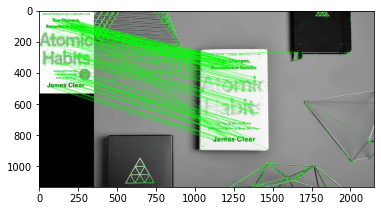

In [104]:
img1 = cv2.imread('images/book.jpeg')
img2 = cv2.imread('images/cluttered_book.jpeg')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

kp1, des1 = extract_sift_features(img1)
kp2, des2 = extract_sift_features(img2)

matches, matchesMask, good = K_NN(kp1, kp2, des1, des2)
draw_matches_knn(img1, img2, kp1, kp2, matches, matchesMask)

# III. Compute Homography

In [111]:
def compute_homography(good, kp1, kp2, max_thres):
    pointsA = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    pointsB = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    homography, status = cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_thres)
    return homography, status

# IV. Find Connected Components of Image Matches

In [84]:
def find_connected(kp1, kp2, desc1, desc2, lowe_ratio, max_thres):
    matches, matchesMask, good = K_NN(kp1, kp2, desc1, desc2, lowe_ratio)
    if len(good) > 4:
        homography, status = compute_homography(good, kp1, kp2, max_thres)
        return good, homography, status
    else:
        return None

# V. Render Panorama

In [99]:
def getwarp_perspective(img1, img2, homography):
    maxWidth = img1.shape[1] + img2.shape[1]
    maxHeight = img1.shape[0] + img2.shape[0]
    result = cv2.warpPerspective(img1, homography, (maxWidth, maxHeight))
    return result

def render(matches, homography, status, img1, img2):
    if (matches, homography, status) is None:
        return None
    result = getwarp_perspective(img1, img2, homography)
    result[0:img2.shape[0], 0:img2.shape[1]] = img2
    return result
    

In [94]:
def image_stitch(images, lowe_ratio=0.75, max_thres=4.0):
    img2, img1 = images
    kp1, desc1 = extract_sift_features(img1)
    kp2, desc2 = extract_sift_features(img2)
    
    connected = find_connected(kp1, kp2, desc1, desc2, lowe_ratio, max_thres)
    if connected is None:
        return img1
    else:
        good, homography, status = connected
        return render(good, homography, status, img1, img2)

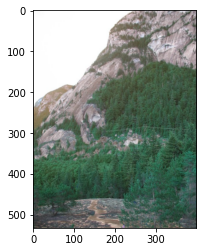

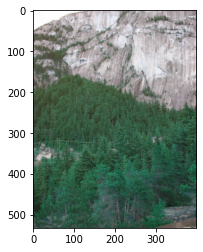

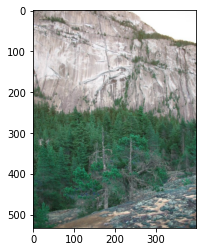

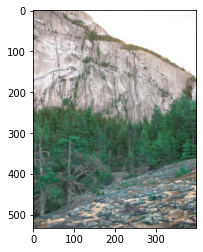

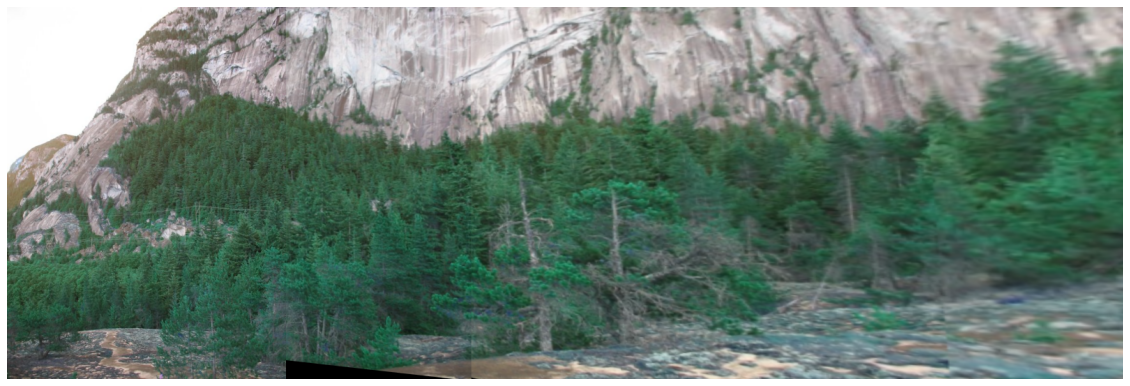

In [112]:
images = load_images_from_folder("images/testset1")
numImages = len(images)

if not len(images):
    result = None
elif len(images) == 1:
    result = images[0]
elif len(images) == 2:
    result = image_stitch([images[0], images[1]])
else:
    result = image_stitch([images[numImages - 2], images[numImages - 1]])
    for i in range(len(images) - 2):
        result  = image_stitch([images[numImages - i - 3], result])

for i in images:
    plt.imshow(i)
    plt.show()
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.axis('off')
plt.show()